In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits

In [2]:
plt.style.use('notebook')

In [3]:
t = Table(fits.getdata('../data/legacysurvey-bricks-dr7.fits.gz'))

In [4]:
ind = (t['ra']>215) & (t['ra']<250) & (t['dec']>-10) & (t['dec']<10)
t = t[ind]

In [5]:
tin = Table(fits.getdata('../data/pal5_ls_lite_grz.fits'))

In [6]:
tflag = Table.read('../data/cmd_masks_orig.fits')

In [7]:
tp = tin[tflag['gr_mask'] & tflag['grz_mask']]

In [8]:
import astropy.units as u

In [9]:
# isochrone
# iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
iso = Table.read('../data/mist_11.5_-1.30.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

distance_app = 22.5*u.kpc
distance_app = 20*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
i_g = iso['DECam_g']+dm
i_r = iso['DECam_r']+dm

In [81]:
pal5_mask = (tin['ra']-229)**2 + (tin['dec']+0.1)**2<0.2**2

points_sky = np.array([tin['ra'], tin['dec']]).T
poly_fan = np.array([[223.5, -5.5], [225.3, -5.5], [224.8, -8.5], [221.5, -8.5]])
poly_fan = np.array([[223.45, -5.5], [225., -5.5], [224.5, -8.5], [221.45, -8.5]])
# poly_fan = np.array([[223.45, -5.5], [224.45, -5.5], [222.45, -8.5], [221.45, -8.5]])
path_fan = mpl.path.Path(poly_fan)
fan_mask = path_fan.contains_points(points_sky)

poly_control = np.copy(poly_fan)
poly_control[:,0] -= 3.6
# poly_control[:,0] -= 2
path_control = mpl.path.Path(poly_control)
control_mask = path_control.contains_points(points_sky)

# scale fan out
s = 0.3
poly_fan[:2,1] += s
poly_fan[2:,1] -= s
poly_fan[1:3,0] += s
poly_fan[0,0] -= s
poly_fan[-1,0] -= s

poly_control = np.copy(poly_fan)
poly_control[:,0] -= 3.6


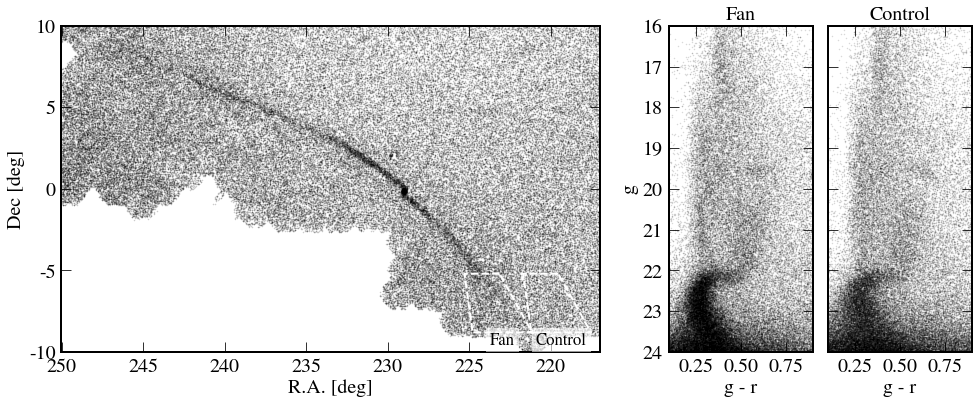

In [98]:
fig = plt.figure(figsize=(13.6,6))
gs1 = mpl.gridspec.GridSpec(1,1)
gs1.update(left=0.05, right=0.6)

gs2 = mpl.gridspec.GridSpec(1,2)
gs2.update(left=0.67, right=0.98, wspace=0.1)

ax0 = fig.add_subplot(gs1[0])
ax1 = fig.add_subplot(gs2[0])
ax2 = fig.add_subplot(gs2[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
ax = [ax0, ax1, ax2]

plt.sca(ax[0])
plt.plot(tp['ra'], tp['dec'], 'k.', ms=3, mec='none', alpha=0.2, rasterized=True)

pfan = mpl.patches.Polygon(poly_fan, color='none', ec='w', ls='--', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pfan)

pcontrol = mpl.patches.Polygon(poly_control, color='none', ec='w', ls='--', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pcontrol)

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.gca().set_aspect('equal')
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))

plt.xlim(248,219)
plt.ylim(-10,10)
plt.gca().set_aspect('equal', adjustable='datalim')

labels = ['Fan', 'Control']
poly_list = [poly_fan, poly_control]
for e, mask in enumerate([fan_mask, control_mask]):
    plt.sca(ax[e+1])
#     plt.plot(i_gr, i_g, '-', color='orangered', alpha=0.3)
    plt.plot(tin['g'][mask]-tin['r'][mask], tin['g'][mask], 'k.', ms=3, mec='none', alpha=0.15, rasterized=True)
    
    plt.xlim(0.1,0.9)
    plt.ylim(24,16)
    plt.xlabel('g - r')
    plt.title(labels[e], fontsize='medium')
    if e==0:
        plt.ylabel('g')

    plt.sca(ax[0])
    txt = plt.text(np.median(poly_list[e][2:,0]), -8.8, labels[e], ha='center', va='top', fontsize='small')
    txt.set_bbox(dict(facecolor='w', alpha=0.6, ec='none'))

# plt.savefig('../plots/map_control_noiso.png')
plt.savefig('../paper/map_fancmd.pdf', dpi=200)